# 4.4: 前馈式矩阵乘积态机器学习模型

> References:
> * [TensorNetwork for Machine Learning](https://arxiv.org/abs/1906.06329)
> * [Residual Matrix Product State for Machine Learning](https://arxiv.org/abs/2012.11841)
>    * ResMPS 很像 RNN

前馈式矩阵乘积态机器学习模型：
* 张量可作为从多个向量到单个向量（或张量）的映射
* 该映射可作为机器学习映射，其变分参数为张量元

步骤：
1. 特征映射 - 将各个特征映射为向量，将样本映射为多个向量的直积（与ADQC类似，见第3.4）
2. 计算特征向量与张量网络的收缩，获得输出向量

结构
![tn_machine](./images/tn_machine.png)

## 残差 MPS (ResMPS)

* 由于MPS长度等于样本特征个数（例如 MNIST 每个样本含784个特征），绝大部分矩阵乘积态会出现"**正交灾难**"（见4.1）
* ResMPS：利用"**残差(residual)**"的思想来避免正交灾难的发生

### 收缩算法

![res_mps_contraction](./images/res_mps_contraction.png)

* 从两端到中间（类别指标处）进行收缩，局域收缩表达式为：
  $$\sum_{\alpha_l s_l} v_{\alpha_l}^{(l)} \phi_{s_l}^{(l)} A_{\alpha_l s_l \alpha_{l+1}}^{(l)} = v_{\alpha_{l+1}}^{(l+1)}$$
* 向量$v^{(0)} = [1]$， $v^{(L-1)} = [1]$（注：最左侧张量的左虚拟指标维数为1，最右侧张量的右虚拟指标维数为1）
* ResMPS 的局域张量满足：$A_{:,0,:}^{(l)} = I$, $|A_{:,1,:}^{(l)}| \sim \varepsilon$
    * 中间指标的 0 分量是 $I$, 而 1 分量的模长是一个小量
* 选取特征映射：$x_l \rightarrow \phi^{(l)} = [1, x_l]$

> 残差项推导：
> 
> 1. ResMPS的局域张量满足: $A_{:,0,:}^{(l)} = I$, $|A_{:,1,:}^{(l)}| \sim \varepsilon$
> 2. 选取特征映射: $x_l \to \phi^{(l)} = [1, x_l]$
> 3. 代入上面的局域收缩表达式得到下面的式子
> 
> $$\boldsymbol{v}^{(l+1)} = \boldsymbol{v}^{(l)} + x_l\boldsymbol{v}^{(l)}A_{:,1,:}^{(l)}$$
> 
> 前半部分是特征和 0 分量（即 $I$ 相乘）得到，后半部分是 1 分量和上一步的 latent 相乘得到的残差项

> 证明：残差为微扰项时，可避免“正交灾难”
>
> 取模得: $|\boldsymbol{v}^{(l-1)}\boldsymbol{A}_{:,1,:}^{(l-1)}| \approx \varepsilon|\boldsymbol{v}^{(l-1)}|$
>
> 代入$\boldsymbol{v}^{(l)} = \boldsymbol{v}^{(l-1)} + x_{l-1}\boldsymbol{v}^{(l-1)}\boldsymbol{A}_{:,1,:}^{(l-1)}$ 并用三角不等式有:
>
> $|\boldsymbol{v}^{(l)}| \leq (1 + |x_{l-1}|\varepsilon)|\boldsymbol{v}^{(l-1)}| \leq (1 + |x_{l-1}|\varepsilon)(1 + |x_{l-2}|\varepsilon)|\boldsymbol{v}^{(l-2)}|$
>
> 仅保留到$\varepsilon$的线性项，有:
>
> $|\boldsymbol{v}^{(l)}| \lesssim [1 + (|x_{l-1}| + |x_{l-2}|)\varepsilon]|\boldsymbol{v}^{(l-2)}|$
>
> 依此类推:
>
> $|\boldsymbol{v}^{(l)}| \lesssim [1 + K\bar{x}\varepsilon]|\boldsymbol{v}^{(l-K)}|$
> 
> 类似地，可以证明 $[1 - K\bar{x}\varepsilon]|\boldsymbol{v}^{(l-K)}| \lesssim |\boldsymbol{v}^{(l)}| $
>
> 即 $\boldsymbol{v}^{(l)}$ 的模长仅近似地随收缩张量个数$K$线性变化，从而避免了指数地增大或缩小


* 实际计算中，可直接处理残差的计算，从而节省计算量
* 定义局域张量{$B^{(l)}$}，局域收缩为
    $$v_{a_{l+1}}^{(l+1)} = v_{a_l}^{(l)} + \sum_{a_l s_l} v_{a_l}^{(l)} \tilde{\phi}_{s_l}^{(l)} B_{a_l s_l a_{l+1}}^{(l)}$$

    $\tilde{\phi}^{(l)}$ 可看作是第 $l$ 个特征 $x_l$ 经过特征映射后所得的向量
* 考虑多个样本的并行处理，方法仍然是加入标记样本数目的指标，上式相应地变为
    $$v_{n a_{l+1}}^{(l+1)} = v_{n a_l}^{(l)} + \sum_{a_l s_l} v_{n a_l}^{(l)} \tilde{\phi}_{n s_l}^{(l)} B_{a_l s_l a_{l+1}}^{(l)}$$
    
    $\tilde{\phi}_{n,:}^{(l)}$ 为第 $n$ 个样本的 $l$ 个特征经过特征映射后所得的向量，指标 $n$ 的维数为样本个数

![res_mps_feature_mapping_comparison](./images/res_mps_feature_mapping_comparison.png)

### Code

In [1]:
# |default_exp mlx.networks.res_mps
# |export
import mlx.core as mx
from mlx import nn
from einops import einsum
from einops.array_api import repeat

#### 残差项推导验证

In [2]:
a_l = 3
s_l = 5
a_l1 = 4

x = mx.random.normal([s_l])
v = mx.random.normal([a_l])
A = mx.random.normal([a_l, s_l, a_l1])

result = einsum(x, v, A, "s_l, a_l, a_l s_l a_l1 -> a_l1")

result1 = 0
for i in range(s_l):
    result1 = result1 + x[i] * (v.reshape(1, a_l) @ A[:, i, :])

result2 = mx.zeros(a_l1)

for i in range(a_l1):
    result2[i] = mx.inner(A[:, :, i] @ x, v)

assert mx.allclose(result, result1)
assert mx.allclose(result, result2)

#### Module

In [3]:
# |export
class ResMPSSimple(nn.Module):
    def __init__(
        self,
        *,
        num_features: int,
        feature_dim: int,
        num_classes: int,
        virtual_dim: int,
        eps_norm: float = 1e-4,
    ):
        super().__init__()
        assert num_features > 0, "num_features must be positive"
        assert num_classes > 0, "num_classes must be positive"
        assert feature_dim > 0, "feature_dim must be positive"
        assert virtual_dim > 0, "virtual_dim must be positive"
        self.num_features = num_features
        self.num_classes = num_classes
        self.virtual_dim = virtual_dim
        self.feature_dim = feature_dim
        self.class_idx = num_features // 2
        local_tensors = []
        dtype = mx.float32
        if num_features == 1:
            local_tensors.append(
                self._make_local_tensor(
                    virtual_dim,
                    feature_dim,
                    virtual_dim,
                    num_classes,
                    dtype=dtype,
                    eps_norm=eps_norm,
                )
            )
        else:
            for i in range(num_features):
                if i == self.class_idx:
                    tensor_shape = (virtual_dim, feature_dim, virtual_dim, num_classes)
                else:
                    tensor_shape = (virtual_dim, feature_dim, virtual_dim)
                local_tensors.append(
                    self._make_local_tensor(*tensor_shape, dtype=dtype, eps_norm=eps_norm)
                )
        self.local_tensors = local_tensors
        contract_vector = mx.ones([virtual_dim], dtype=dtype)
        contract_vector /= mx.linalg.norm(contract_vector)
        self.contract_vector = contract_vector

    @staticmethod
    def _make_local_tensor(*shape: int, dtype: mx.Dtype, eps_norm: float) -> mx.array:
        tensor = mx.random.normal(shape, dtype=dtype)
        tensor /= mx.linalg.norm(tensor)
        tensor = tensor * eps_norm
        return tensor

    @mx.compile
    def calc(self, features: mx.array) -> mx.array:
        batch_size, num_features, feature_dim = features.shape
        latent_left = repeat(
            mx.stop_gradient(self.contract_vector),
            "virtual_left -> batch virtual_left",
            batch=batch_size,
        )
        for feature_idx in range(self.class_idx):
            latent = einsum(
                self.local_tensors[feature_idx],
                latent_left,
                features[:, feature_idx, :],
                "left feature right, batch left, batch feature -> batch right",
            )
            latent_left = latent + latent_left  # residual

        latent_right = repeat(
            mx.stop_gradient(self.contract_vector),
            "virtual_right -> batch virtual_right",
            batch=batch_size,
        )
        for feature_idx in range(num_features - 1, self.class_idx, -1):
            latent = einsum(
                self.local_tensors[feature_idx],
                latent_right,
                features[:, feature_idx, :],
                "left feature right, batch right, batch feature -> batch left",
            )
            latent_right = latent + latent_right  # residual

        activation = einsum(
            self.local_tensors[self.class_idx],
            latent_left,
            latent_right,
            features[:, self.class_idx, :],
            "left feature right classes, batch left, batch right, batch feature -> batch classes",
        )
        return activation

    @mx.compile
    @staticmethod
    def calc(
        local_tensors: list[mx.array],
        contract_vector: mx.array,
        features: mx.array,
        class_idx: int,
    ) -> mx.array:
        batch_size, num_features, _ = features.shape
        latent_left = repeat(
            mx.stop_gradient(contract_vector),
            "virtual_left -> batch virtual_left",
            batch=batch_size,
        )
        for feature_idx in range(class_idx):
            latent = einsum(
                local_tensors[feature_idx],
                latent_left,
                features[:, feature_idx, :],
                "left feature right, batch left, batch feature -> batch right",
            )
            latent_left = latent + latent_left  # residual

        latent_right = repeat(
            mx.stop_gradient(contract_vector),
            "virtual_right -> batch virtual_right",
            batch=batch_size,
        )
        for feature_idx in range(num_features - 1, class_idx, -1):
            latent = einsum(
                local_tensors[feature_idx],
                latent_right,
                features[:, feature_idx, :],
                "left feature right, batch right, batch feature -> batch left",
            )
            latent_right = latent + latent_right  # residual

        activation = einsum(
            local_tensors[class_idx],
            latent_left,
            latent_right,
            features[:, class_idx, :],
            "left feature right classes, batch left, batch right, batch feature -> batch classes",
        )
        return activation

    def __call__(self, features: mx.array) -> mx.array:
        # features shape: (batch_size, num_features, feature_dim)
        _, num_features, feature_dim = features.shape
        assert num_features == self.num_features, (
            f"num_features must be equal to {self.num_features}"
        )
        assert feature_dim == self.feature_dim, f"feature_dim must be equal to {self.feature_dim}"
        return self.calc(
            self.local_tensors,
            self.contract_vector,
            features,
            self.class_idx,
        )

#### Training

In [4]:
# TODO: export this
def linear_mapping(samples: mx.array) -> mx.array:
    """
    Apply linear feature mapping

    Args:
        samples: Input tensor of shape (batch_size, *)

    Returns:
        Output tensor of shape (batch_size, *, 2)
    """
    if samples.ndim == 1:
        samples = samples.reshape(1, -1)

    return mx.stack([samples, 1 - samples], -1)

In [5]:
from tensor_network.utils.data import get_fashion_mnist_datasets
import os
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
from einops import rearrange
import matplotlib.pyplot as plt
import mlx.optimizers as optim

cwd = os.getcwd()
cache_path = os.path.join(cwd, "datasets")

In [6]:
fmnist_trainset, fmnist_testset = get_fashion_mnist_datasets(cache_path)

In [7]:
# hyperparameters
device = mx.gpu
mx.default_stream(device)
batch_size = 2000
lr = 1e-4
epochs = 30

feature_dim = 2
virtual_dim = 50

In [8]:
train_loader = DataLoader(fmnist_trainset, batch_size, True)
test_loader = DataLoader(fmnist_testset, batch_size, False)
num_classes = 10

In [9]:
model = ResMPSSimple(
    num_features=28 * 28,
    feature_dim=feature_dim,
    num_classes=num_classes,
    virtual_dim=virtual_dim,
    eps_norm=1e-4,
)

parameters = model.parameters()
mx.eval(parameters)
optimizer = optim.Adam(learning_rate=lr)


def loss_fn(model: ResMPSSimple, input_data: mx.array, target: mx.array) -> mx.array:
    return mx.mean(nn.losses.cross_entropy(model(input_data), target))


loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

In [10]:
# TODO: add test accuracy
# FIXME: the training speed is too slow
losses = mx.zeros([epochs])
mx.eval(losses)
train_accuracies = mx.zeros([epochs])
progress_bar = tqdm(range(epochs))

for epoch in progress_bar:
    # train_acc = MulticlassAccuracy(num_classes=num_classes)
    batch_loss = 0.0
    num = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        data = rearrange(data, "b c h w -> b (c h w)")
        data = mx.array(data.numpy())
        data = linear_mapping(data)
        target = mx.array(target.numpy())
        loss, grads = loss_and_grad_fn(model, data, target)
        optimizer.update(model, grads)
        mx.eval(model.parameters(), optimizer.state)
        num += batch_size
        batch_loss += loss.item() * batch_size
        # train_acc.update(output.detach(), target)
    losses[epoch] = batch_loss / num
    # train_accuracies[epoch] = train_acc.compute()
    progress_bar.set_description(f"Epoch {epoch} loss: {losses[epoch]:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

In [11]:
# TODO: add test accuracy and plots

# test_acc = MulticlassAccuracy(num_classes=num_classes).to(device)
# with torch.no_grad():
#     for data, target in tqdm(test_loader):
#         batch_size = data.shape[0]
#         data = data.to(device)
#         data = rearrange(data, "b c h w -> b (c h w)")
#         target = target.to(device)
#         data = linear_mapping(data)
#         output = model(data)
#         test_acc.update(output, target)


# test_acc = test_acc.compute()
# print(f"Test accuracy: {test_acc}")

In [12]:
# plt.figure(figsize=(10, 6))
# plt.plot(range(epochs), train_accuracies, label="Train Accuracy")
# # plt.axhline(y=test_acc.cpu(), color="r", linestyle="--", label="Test Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.title("Training and Test Accuracy")
# plt.legend()
# plt.grid(True)

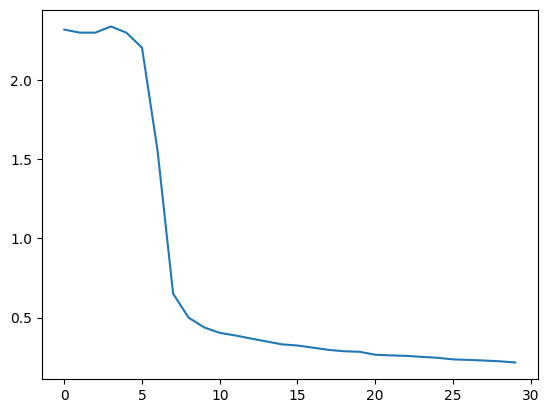

In [13]:
plt.plot(range(epochs), losses)